In [ ]:
%pip install rasterio
%pip install torchgeo==0.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 41.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.1/279.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.7 MB/s eta 0:00

In [ ]:
from google.colab import drive

In [ ]:
!unzip /content/drive/MyDrive/dset-s2.zip -d /
#!unzip dset-s2.zip

Archive:  /content/drive/MyDrive/dset-s2.zip
   creating: /dset-s2/
  inflating: /__MACOSX/._dset-s2     
   creating: /dset-s2/tra_truth/
   creating: /dset-s2/val_truth/
   creating: /dset-s2/tra_scene/
   creating: /dset-s2/val_scene/
  inflating: /dset-s2/tra_truth/S2A_L2A_20190817_N0213_R089_S1_Truth.tif  
  inflating: /dset-s2/tra_truth/S2B_L2A_20190818_N0213_R035_S1_Truth.tif  
  inflating: /dset-s2/tra_truth/S2A_L2A_20190716_N0213_R063_S3_Truth.tif  
  inflating: /dset-s2/tra_truth/S2A_L2A_20190314_N0211_R008_S1_Truth.tif  
  inflating: /dset-s2/tra_truth/S2B_L2A_20190807_N0213_R018_S2_Truth.tif  
  inflating: /dset-s2/tra_truth/S2B_L2A_20190904_N0213_R132_S2_Truth.tif  
  inflating: /dset-s2/tra_truth/S2A_L2A_20190811_N0213_R013_S2_Truth.tif  
  inflating: /dset-s2/tra_truth/S2B_L2A_20190506_N0212_R126_S3_Truth.tif  
  inflating: /dset-s2/tra_truth/S2A_L2A_20190206_N0211_R067_S1_Truth.tif  
  inflating: /dset-s2/tra_truth/S2A_L2A_20190125_N0211_R034_S1_Truth.tif  
  inflating:

In [ ]:
from pathlib import Path
from typing import Iterable, List
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch

In [ ]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [ ]:
root = Path('/dset-s2')
assert root.exists()

In [ ]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [ ]:
train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

valid_imgs = RasterDataset(root=(root/'val_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'val_truth').as_posix(), crs='epsg:3395', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=130, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=64, units=Units.PIXELS)


In [ ]:
bbox = next(iter(train_sampler))
bbox

BoundingBox(minx=13792876.908310799, maxx=13797996.908310799, miny=9129856.641024875, maxy=9134976.641024875, mint=0.0, maxt=9.223372036854776e+18)

In [ ]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['image', 'crs', 'bbox', 'mask'])

In [ ]:
sample['image'].shape, sample['mask'].shape

(torch.Size([6, 512, 512]), torch.Size([1, 512, 512]))

In [ ]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['image', 'crs', 'bbox', 'mask']),
 dict_keys(['image', 'crs', 'bbox', 'mask']))

In [ ]:
from typing import Iterable, List, Optional, Callable
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright)

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2])

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright)

        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1))

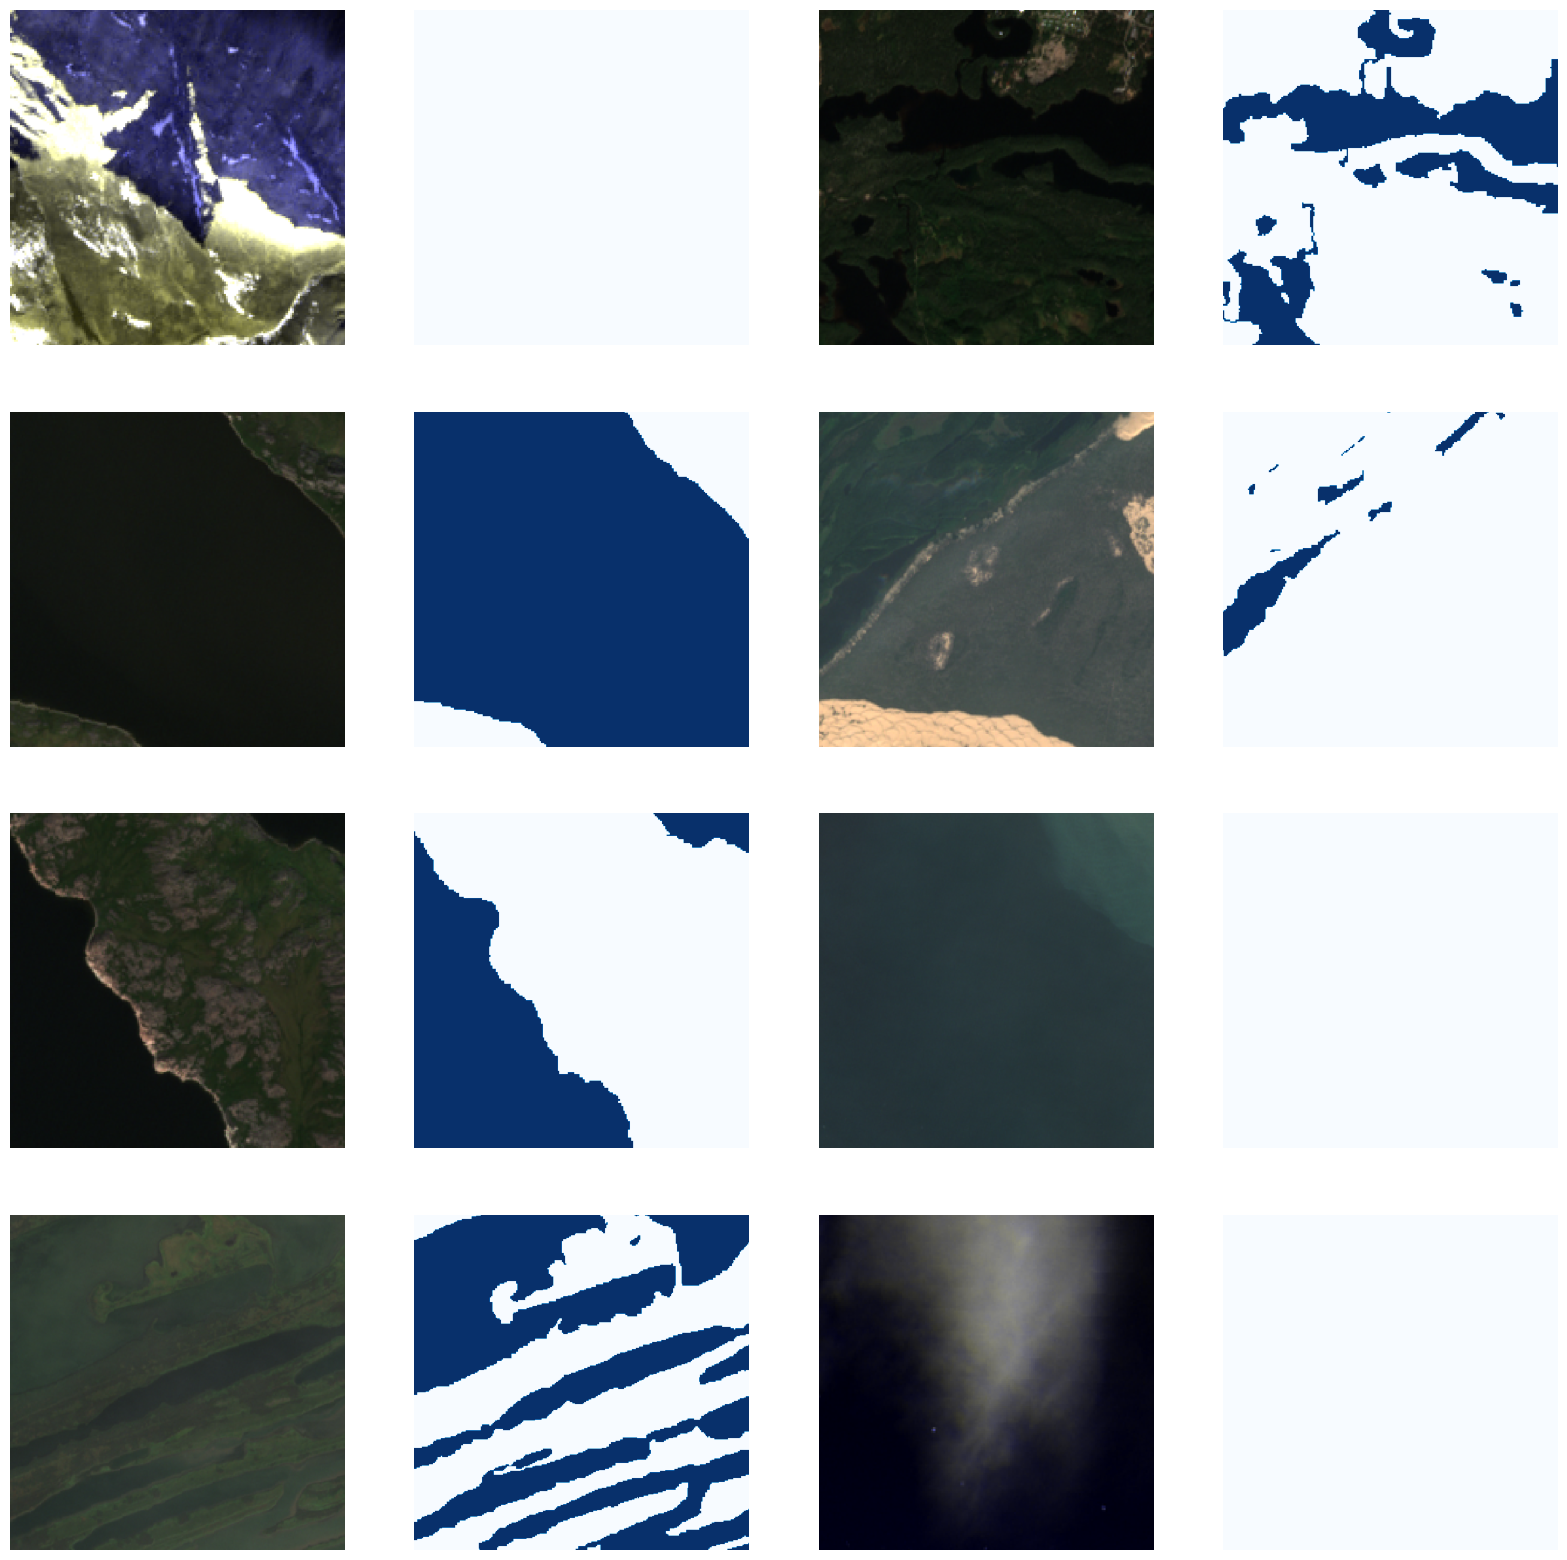

In [ ]:
plot_batch(train_batch)

In [ ]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [ ]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs


In [ ]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=5),
    indices.AppendNDVI(index_nir=3, index_red=2),
    normalize
)

In [ ]:
transformed_batch = tfms(train_batch)
print(transformed_batch['image'].shape, transformed_batch['mask'].shape)

torch.Size([8, 9, 512, 512]) torch.Size([8, 1, 512, 512])


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=9,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(3, 9, 512, 512))
pred['out'].shape

torch.Size([3, 2, 512, 512])

In [ ]:
def train_loop(
    epochs: int,
    train_dl: DataLoader,
    val_dl: Optional[DataLoader],
    model: torch.nn.Module,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    acc_fns: Optional[List]=None,
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    cuda_model = model.cuda()

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch['image'].cuda()
            y = batch['mask'].type(torch.long).cuda()
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch = batch_tfms(batch)

                    X = batch['image'].type(torch.float32).cuda()
                    y = batch['mask'].type(torch.long).cuda()

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:

            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

In [ ]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):
    return torch.nn.functional.cross_entropy(p, t.squeeze())

In [ ]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
train_loop(15, train_dataloader, valid_dataloader, model, loss, optimizer,
           acc_fns=[oa, iou], batch_tfms=tfms)

Epoch 0: Train Loss=0.45154 - Accs=[0.932, 0.714]
Epoch 1: Train Loss=0.30231 - Accs=[0.936, 0.625]
Epoch 2: Train Loss=0.29744 - Accs=[0.946, 0.731]
Epoch 3: Train Loss=0.26823 - Accs=[0.943, 0.757]
Epoch 4: Train Loss=0.18358 - Accs=[0.96, 0.728]
Epoch 5: Train Loss=0.18431 - Accs=[0.954, 0.714]
Epoch 6: Train Loss=0.19164 - Accs=[0.966, 0.761]
Epoch 7: Train Loss=0.18181 - Accs=[0.966, 0.808]
Epoch 8: Train Loss=0.15470 - Accs=[0.962, 0.804]
Epoch 9: Train Loss=0.14559 - Accs=[0.954, 0.717]
Epoch 10: Train Loss=0.15403 - Accs=[0.958, 0.738]
Epoch 11: Train Loss=0.13377 - Accs=[0.975, 0.843]
Epoch 12: Train Loss=0.14334 - Accs=[0.97, 0.778]
Epoch 13: Train Loss=0.11182 - Accs=[0.97, 0.831]
Epoch 14: Train Loss=0.10079 - Accs=[0.971, 0.818]
